In this notebook we calculate Stored Carbon from an ISRIC dataset, more specifically the ISRIC-WISE Harmonized Global Soil Profile Dataset v3.1 available here: https://data.isric.org/geonetwork/srv/eng/catalog.search#/metadata/a351682c-330a-4995-a5a1-57ad160e621c"

The dataset (in MS Access format) was downloaded and split into .csv files, available in a .zip here:

https://drive.google.com/file/d/1wuhyplJ7klD4hV7BsAGSalnXjc5a4GK4/view?usp=sharing

In [24]:
using Pkg

In [25]:
Pkg.add(["Plots","DataFrames", "CSV", "Query", "StatsBase"])

  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`


In [26]:
using Plots, DataFrames, CSV, Query, StatsBase

Let's import the soil horizon data:

In [27]:
df_horizon_orig = CSV.read("WISE3_HORIZON.csv", DataFrame)

┌ Warning: thread = 1 warning: only found 30 / 31 columns around data row: 47834. Filling remaining columns with `missing`
└ @ CSV /Users/Daniele/.julia/packages/CSV/la2cd/src/file.jl:603


,WISE3_ID,HONU,DESIG,TOPDEP,BOTDEP,MCOLOR,DCOLOR,ORGC,TOTN,CACO3
,String,Int64,String?,Int64,Int64,String?,String?,String?,String?,String?
1,AF0001,1,missing,0,15,10YR4/3,10YR4/2,"7,6","0,6",93
2,AF0001,2,missing,15,60,10YR5/3,10YR5/2,"2,3","0,3",177
3,AF0001,3,missing,60,150,10YR5/3,missing,"0,9","0,3",182
4,AF0002,1,missing,0,20,10YR4/2,missing,"12,8","0,9",191
5,AF0002,2,missing,20,60,10YR4/2,missing,6,"0,6",192
6,AF0002,3,missing,60,110,10YR4/3,missing,"3,9","0,6",203
7,AF0002,4,missing,110,170,10YR4/3,missing,"2,7",missing,240
8,AF0003,1,A,0,20,10YR4/2,missing,"5,9","0,7",169
9,AF0003,2,Bg,20,50,10YR4/2,missing,"2,4","0,4",138


First pass cleaning:

In [28]:
df_hz = df_horizon_orig |> 
    #pick only relevant columns	
    @select(:WISE3_ID,:HONU,:DESIG,:TOPDEP,:BOTDEP,:ORGC,:BULKDENS) |>

    #drop layers we can't have missing values for
    @dropna(:BULKDENS,:ORGC,:TOPDEP,:BOTDEP) |>

    #includes only layers with bot_depth greater than top_depth
    @filter(_.BOTDEP > _.TOPDEP) |> 

    #filters out organic layers (missings -> Z, keep if neither 'O' or 'o' in DESIG)
    @replacena(:DESIG=>"Z") |>
    @filter(!occursin("O",_.DESIG) && !occursin("o",_.DESIG)) |> 

    #parse ORGC values and keep only non-negative ones
    @mutate(ORGC = replace(_.ORGC,','=>'.')) |>
    @mutate(ORGC = parse(Float64, _.ORGC)) |>
    @filter(_.ORGC >= 0) |>

    #parse BULKDENS values and keep only positive ones
    @mutate(BULKDENS = replace(_.BULKDENS,','=>'.')) |>
    @mutate(BULKDENS = parse(Float64, _.BULKDENS)) |>
    @filter(_.BULKDENS > 0) |> 

    #keep only unique values
    @unique() |> 

    DataFrame #13856 layers

,WISE3_ID,HONU,DESIG,TOPDEP,BOTDEP,ORGC,BULKDENS
,String,Int64,String,Int64,Int64,Float64,Float64
1,AL0007,1,Ap,0,25,9.8,1.64
2,AL0007,2,AB,25,49,7.8,1.62
3,AL0007,3,Bw1,49,83,5.9,1.57
4,AL0007,4,Bw2,83,116,6.9,1.63
5,AL0007,5,2C1,116,147,4.6,1.56
6,AL0007,6,2C2,147,160,4.6,1.45
7,AL0008,1,Ap-,0,17,11.5,1.61
8,AL0008,2,Bw1,17,38,8.1,1.55
9,AL0008,3,2Bw2,38,66,1.7,1.18


First stab at evaluating profiles for layer continuity:

In [29]:
function continuity_check(profile) 
    #the function assumes layers are ordered (e.g.  0 -> 20 -> 40)

    top = profile.TOPDEP
    bot = profile.BOTDEP

    n_layers = length(top)

    #1st layer is always good, from 2nd we check for matching depths at bot/top
    mask = append!([true],[top[l] == bot[l-1] for l in 2:n_layers])

    #if we run into a non-matching layer, we mark as 'false' all following ones
    first_noMatch_id = findfirst(!, mask)

    if isnothing(first_noMatch_id) == false
        mask[first_noMatch_id:end] .= false
    end

    return mask	
end


continuity_check (generic function with 1 method)

In [30]:
#as we keep at least the first layer of each profile, this list won't change 
unique_profiles = unique(df_hz.WISE3_ID);

In [31]:
#computing continuous layers for the whole set, it'll be something like [true true false ...]

layers_keep = Vector{Bool}(undef,0)

for profile in unique_profiles

    append!(layers_keep,continuity_check(df_hz[df_hz.WISE3_ID.==profile,:]))
end


An example of 'troubling' profile, 'AL00017':

In [32]:
df_horizon_orig |> @filter(_.WISE3_ID == "AL0017") |>
                   @select(:WISE3_ID, :HONU, :BULKDENS) |> 
                    DataFrame

,WISE3_ID,HONU,BULKDENS
,String,Int64,String?
1,AL0017,1,"1,57"
2,AL0017,2,"1,97"
3,AL0017,3,"1,59"
4,AL0017,4,"1,59"
5,AL0017,5,missing
6,AL0017,6,"1,67"
7,AL0017,7,"1,66"
8,AL0017,8,missing


Bulk density is missing from layer #5 and #8 in the starting dataset

In [33]:
test_profile = df_hz[df_hz.WISE3_ID .== "AL0017",:]

,WISE3_ID,HONU,DESIG,TOPDEP,BOTDEP,ORGC,BULKDENS
,String,Int64,String,Int64,Int64,Float64,Float64
1,AL0017,1,Ap1,0,16,28.6,1.57
2,AL0017,2,Ap2,16,37,26.9,1.97
3,AL0017,3,Bt1,37,55,23.0,1.59
4,AL0017,4,Bt2,55,77,22.8,1.59
5,AL0017,6,3Bw1,85,112,28.7,1.67
6,AL0017,7,3Cg1,112,130,68.7,1.66


In [34]:
continuity_check(test_profile)

6-element Array{Bool,1}:
 1
 1
 1
 1
 0
 0

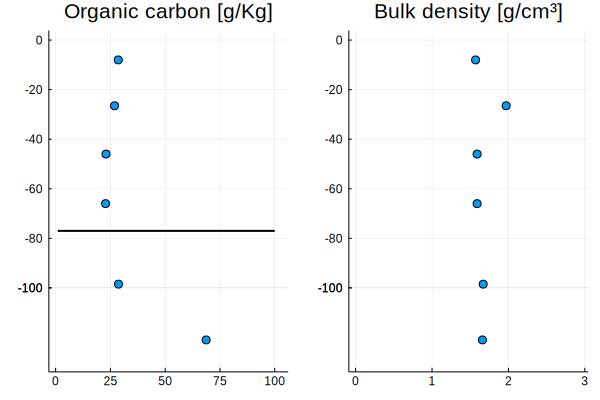

In [50]:
#top and bottom for each layer
td = test_profile.TOPDEP
bp = test_profile.BOTDEP

#values
blk = test_profile.BULKDENS
orgc = test_profile.ORGC

#plotting utilities
y_mid = (td .+ bp)./2 
y_lim = [-maximum(bp),minimum(td)]
x_lim_orgc = [0,maximum(orgc)*1.5]
x_lim_blk = [0,maximum(blk)*1.5]


# ORGC plot
p_orgc_or=scatter(orgc,-y_mid, legend=nothing, xlim=x_lim_orgc, ylim=y_lim, title="Organic carbon [g/Kg]")

# BULKDENS 
p_blk_or =scatter(blk,-y_mid, legend=nothing, xlim=x_lim_blk, ylim=y_lim, title="Bulk density [g/cm³]")

#CLIP DEPTH
clip_depth_id = findlast(continuity_check(test_profile))
clip_depth = bp[clip_depth_id]

#Plotting
plot!(p_orgc_or, -ones(100)*clip_depth, width = 2, color = :black)
plot(p_orgc_or, p_blk_or)


In [36]:
#DF we can work with
df_hz_ready = df_hz[layers_keep,:]

,WISE3_ID,HONU,DESIG,TOPDEP,BOTDEP,ORGC,BULKDENS
,String,Int64,String,Int64,Int64,Float64,Float64
1,AL0007,1,Ap,0,25,9.8,1.64
2,AL0007,2,AB,25,49,7.8,1.62
3,AL0007,3,Bw1,49,83,5.9,1.57
4,AL0007,4,Bw2,83,116,6.9,1.63
5,AL0007,5,2C1,116,147,4.6,1.56
6,AL0007,6,2C2,147,160,4.6,1.45
7,AL0008,1,Ap-,0,17,11.5,1.61
8,AL0008,2,Bw1,17,38,8.1,1.55
9,AL0008,3,2Bw2,38,66,1.7,1.18


Calculating orgc storage as:  BULKDENS [g / cm³] x AREA [m²] x ORGC [g / Kg] for each layer in each profile.

The result will be in [Kg].

In [37]:
function orgc_storage(profile) 

    top = profile.TOPDEP
    bot = profile.BOTDEP

    blk = profile.BULKDENS
    orgc = profile.ORGC

    layer_height = (bot.-top)

    mass=0.0
    for sc in 1:length(layer_height)

        mass += blk[sc]*orgc[sc]*layer_height[sc]/100
    end

    return mass

end

orgc_storage (generic function with 1 method)

In [38]:
orgc_mass = Dict()

for profile in unique_profiles
    orgc_mass[profile] = orgc_storage(df_hz_ready[df_hz_ready.WISE3_ID.==profile,:])
end

df_stored_ORGC = sort!(DataFrame(WISE3_ID = String.(keys(orgc_mass)), 
                                 STORED_ORGC = Float64.(values(orgc_mass))))

,WISE3_ID,STORED_ORGC
,String,Float64
1,AL0007,17.0032
2,AL0008,6.79968
3,AL0009,10.19
4,AL0010,16.182
5,AL0011,19.5227
6,AL0012,12.7518
7,AL0013,14.3507
8,AL0014,13.6746
9,AL0015,23.7756


Let's enrich the data with extra information for each profile:

In [39]:
df_site_orig = CSV.read("WISE3_SITE.csv", DataFrame)

,WISE3_id,ISO,DESCR,DATEYR,DATEMON,SOLDEP,HORNUM,FAO_90,PHA_90,FAO_74
,String,String,Int64,Int64?,Int64?,Int64,Int64,String,String?,String?
1,AF0001,AF,3,1962,missing,150,3,CLl,missing,Bk
2,AF0002,AF,3,1962,missing,170,4,FLc,missing,Jc
3,AF0003,AF,3,1962,missing,110,3,FLc,missing,Jc
4,AF0004,AF,3,1962,missing,270,6,SCg,missing,Zo
5,AF0005,AF,3,1962,missing,190,6,SCk,missing,Zo
6,AL0001,AL,4,1981,9,94,4,LVk,missing,Lk
7,AL0002,AL,4,1983,9,87,3,LPk,missing,Be
8,AL0003,AL,4,1985,12,85,3,LVf,missing,Lf
9,AL0004,AL,4,1991,11,120,6,CMc,missing,Bk


Filtering on the SITE dataset:

In [40]:
df_site = df_site_orig |>
    @select(:WISE3_id, :DATEYR, :LONDD, :LATDD) |>
    @dropna(:LONDD,:LATDD) |>
    @rename(:WISE3_id => :WISE3_ID) |>

    #parse LONDD values
    @mutate(LONDD = replace(_.LONDD,','=>'.')) |>
    @mutate(LONDD = parse(Float64, _.LONDD)) |>

    #parse LATDD values
    @mutate(LATDD = replace(_.LATDD,','=>'.')) |>
    @mutate(LATDD = parse(Float64, _.LATDD)) |>

    DataFrame

,WISE3_ID,DATEYR,LONDD,LATDD
,String,Int64?,Float64,Float64
1,AF0001,1962,69.1667,34.5
2,AF0002,1962,69.1667,34.5
3,AF0003,1962,69.1667,34.5
4,AF0004,1962,61.4333,34.3333
5,AF0005,1962,62.1333,32.3833
6,AL0001,1981,20.75,40.6167
7,AL0002,1983,20.3006,39.635
8,AL0003,1985,20.3861,42.2222
9,AL0004,1991,19.5611,41.0778


Some layers have been dropped.
Retrieving min_depth and max_depth for each profile.

In [41]:
function depth(profile) 

top = profile.TOPDEP
bot = profile.BOTDEP

return (minimum(top), maximum(bot))
end

depth (generic function with 1 method)

In [42]:
profiles_depth = Dict()

for profile in unique_profiles
    profiles_depth[profile] = depth(df_hz_ready[df_hz_ready.WISE3_ID.==profile,:])
end

df_depths = sort!(DataFrame(WISE3_ID = String.(keys(profiles_depth)), 
                            min_depth = [min for (min,_) in values(profiles_depth)],
                            max_depth = [max for (_,max) in values(profiles_depth)]))


,WISE3_ID,min_depth,max_depth
,String,Int64,Int64
1,AL0007,0,160
2,AL0008,0,100
3,AL0009,0,97
4,AL0010,0,110
5,AL0011,0,130
6,AL0012,0,173
7,AL0013,0,180
8,AL0014,0,130
9,AL0015,0,180


Joining everything:

In [43]:
#add date and location data
df_join_Date_Loc = innerjoin(df_stored_ORGC, df_site, on = :WISE3_ID)

#add min_depth and max_depth data
df_final = innerjoin(df_join_Date_Loc, df_depths, on = :WISE3_ID)

rename!(df_final, lowercase.(names(df_final)))

,wise3_id,stored_orgc,dateyr,londd,latdd,min_depth,max_depth
,String,Float64,Int64?,Float64,Float64,Int64,Int64
1,AL0007,17.0032,1994,19.9956,41.0694,0,160
2,AL0008,6.79968,1994,20.6472,40.215,0,100
3,AL0009,10.19,1994,20.7844,40.6372,0,97
4,AL0010,16.182,1994,19.4836,40.3453,0,110
5,AL0011,19.5227,1994,19.7703,41.3778,0,130
6,AL0012,12.7518,1994,20.9589,40.6553,0,173
7,AL0013,14.3507,1994,20.7325,40.5644,0,180
8,AL0014,13.6746,1994,20.4064,41.6928,0,130
9,AL0015,23.7756,1994,19.7625,41.37,0,180


Results here:

https://drive.google.com/file/d/1ujWu4tYYcy5khvpJOpKL95DgoXRKMiUu/view?usp=sharing